In [1]:
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import random

from scipy.signal import convolve2d
from scipy.ndimage import convolve

from perlin_noise import perlin_noise
from flood_fill import flood_fill

In [2]:
plt.rcParams['figure.figsize'] = (16,12)
np.random.seed(1234)

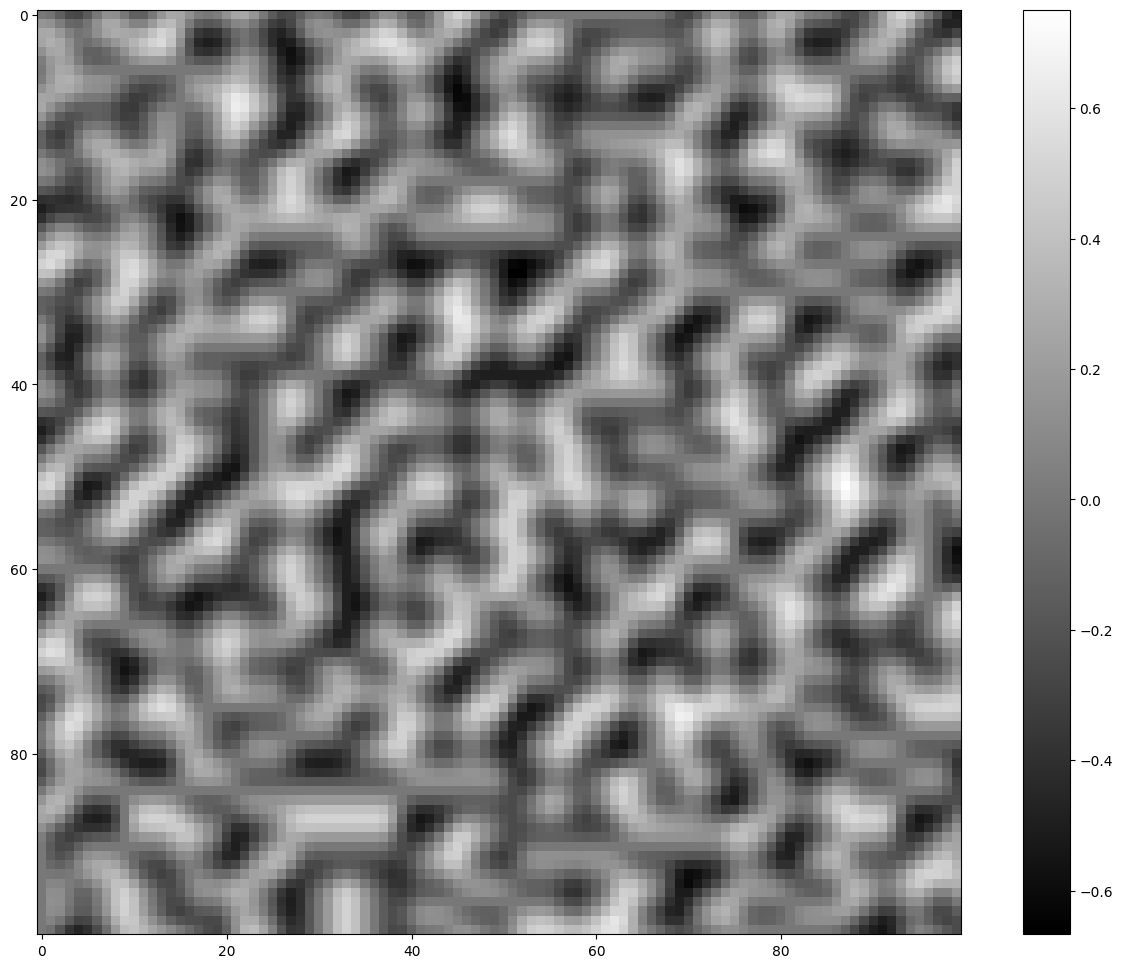

In [3]:
# Generate and display the Perlin noise
width, height = 100, 100
perlin_noise_grid = perlin_noise(width, height, scale=6)

# Display the generated Perlin noise
plt.imshow(perlin_noise_grid, cmap='gray')
plt.colorbar()
plt.show()


-0.6666666666666667 0.75 0.003946803078798962


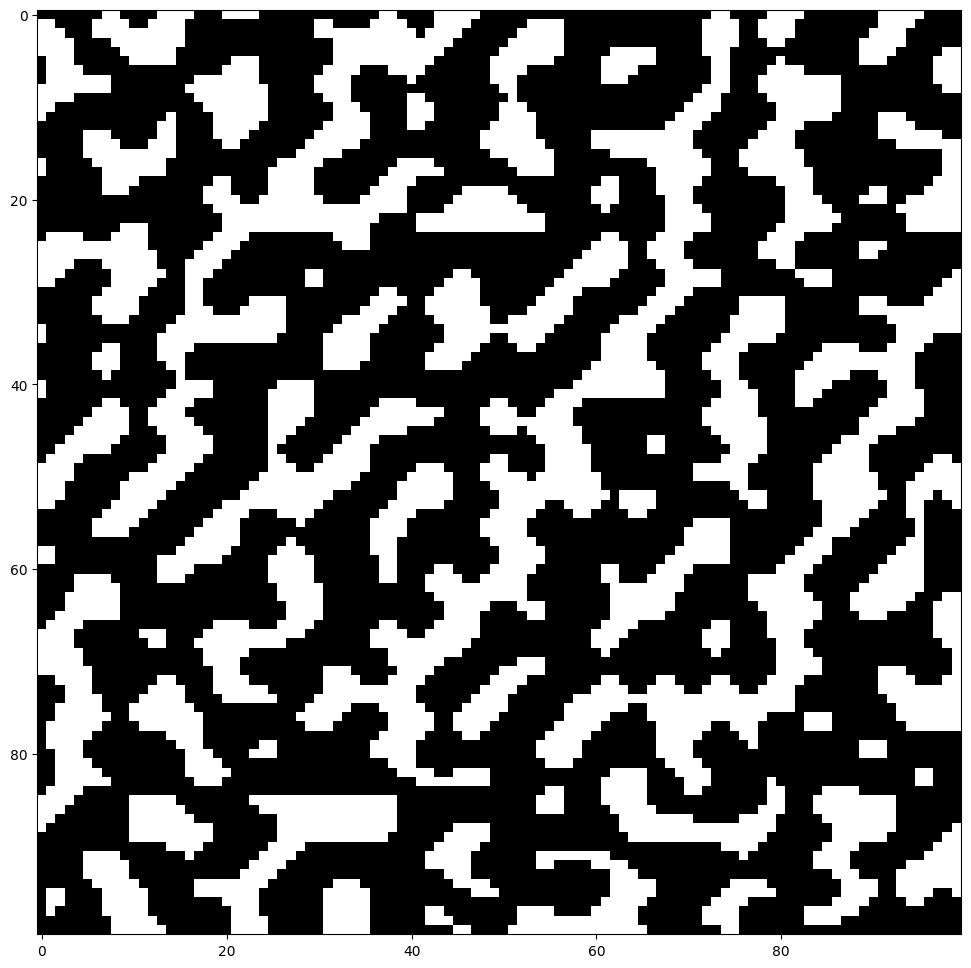

In [4]:
p = perlin_noise_grid
print(np.min(p),np.max(p),np.mean(p))

grid = (p > 0.1) * 1
grid = np.float32(grid)
plt.imshow(grid, cmap='grey')
plt.show()

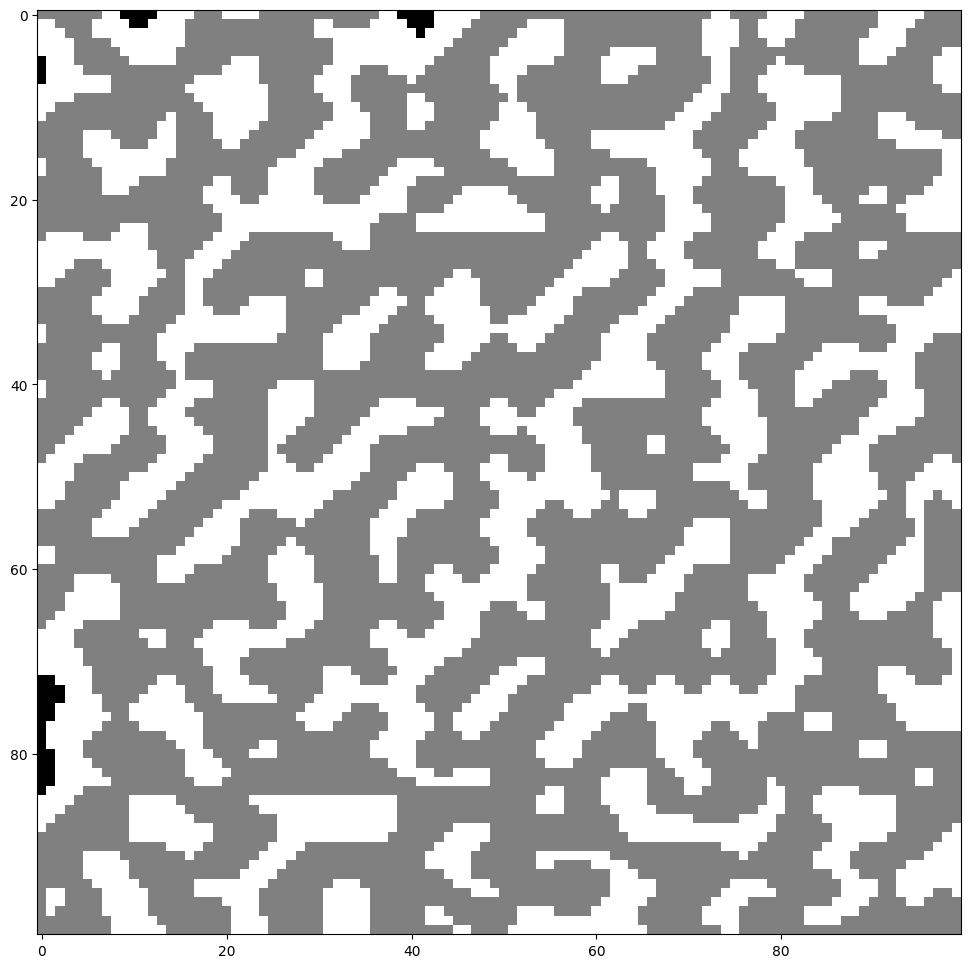

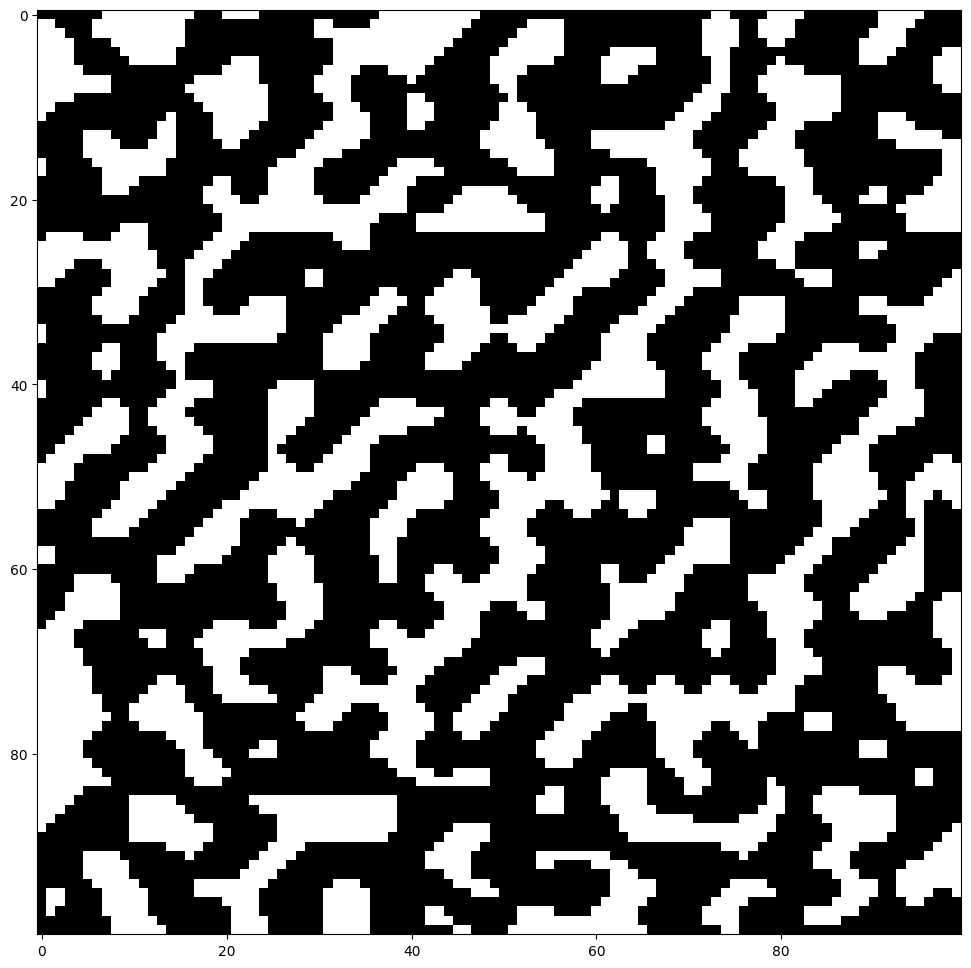

In [5]:
grid_copy = grid.copy()
flood_fill(grid_copy, start_point=(0,0), new_value=0.5)

plt.imshow(grid_copy, cmap='grey')
plt.show()

mask = (grid_copy == 0)
new_grid = grid + mask

plt.imshow(new_grid, cmap='grey')
plt.show()

## Spawning the agent
- Sample random cell
- if empty
  - Spawn point
- else
  - sample again

In [6]:
def spawn_point(grid):
    """
    Spawn the agent at a random point in any point
    """
    h,w = grid.shape

    start_cell = 1
    while start_cell != 0:
        x = random.randint(0,w-1)
        y = random.randint(0,h-1)
        
        start_cell = grid[x,y]

    return np.array((x,y))

## Movement
 - Randomly move in direction
 - If collision
   - Return to same state
 - Else
   - Keep moving

Covered 


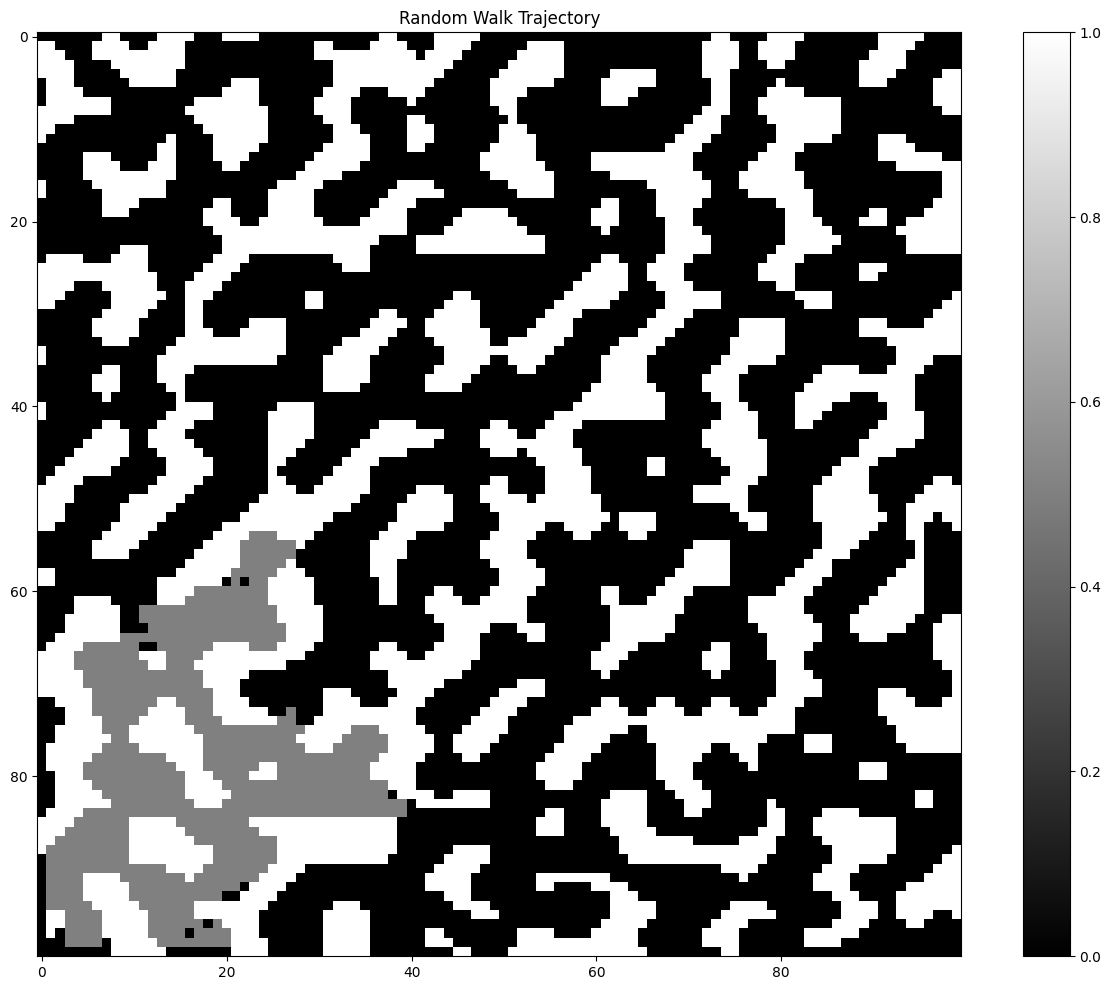

In [7]:
# Assuming grid dimensions are defined
height, width = 100, 100  # Example grid size

# Initialize starting position
current_pos = spawn_point(grid)
x,y = current_pos

# Initialize the trajectory grid and list to track the trajectory
transversed_grid = grid.copy()
trajectory = []

# Number of steps for the random walk
steps = 10000

for i in range(steps):
    # Possible directions for movement (up, down, left, right)
    directions = [(0, 1), (0, -1), (-1, 0), (1, 0)]

    # Randomly choose a direction
    move = random.choice(directions)

    # Calculate the new position
    new_pos = current_pos + move

    # Ensure the new position is within the grid boundaries
    if 0 < new_pos[0] < height-1 and 0 < new_pos[1] < width-1 and grid[tuple(new_pos)] != 1:
        current_pos = new_pos       
        trajectory.append(tuple(current_pos))

cells_covered = len(trajectory)
empty_cells = np.count_nonzero(grid==0)

for point in trajectory:
    transversed_grid[point] = 0.5

print(f'Covered ')
# Display the trajectory as a heatmap
plt.imshow(transversed_grid, cmap='gray')
plt.title("Random Walk Trajectory")
plt.colorbar()
plt.show()

## Visibliity
 - Agent can see 5x5 or 3x3 around them
 - Implement by slicing  grid points
 - Initialize unknow global map
 - Update map by slicing information

In [78]:
def hsv_to_rgb(h):
    hsv_color = np.uint8([[[h*179,255,255]]])
    bgr_color = cv2.cvtColor(hsv_color, cv2.COLOR_HSV2BGR)
    return bgr_color/255

In [82]:
def red_to_blue_gradient(size):
    """Generates a red to blue color gradient.

    Args:
        size: The number of steps in the gradient.

    Returns:
        A numpy array representing the gradient as RGB values.
    """
    red_start = np.array([1, 0, 0])  # RGB for red
    blue_end = np.array([0, 0, 1])  # RGB for blue

    gradient_colors = np.linspace(red_start, blue_end, size)
    return gradient_colors


In [79]:
def hsv_gradient(start_hue, end_hue, steps):
    """
    Generates an HSV color gradient.

    Args:
        start_hue: Starting hue value (0-1).
        end_hue: Ending hue value (0-1).
        steps: Number of steps in the gradient.

    Returns:
        A NumPy array of RGB colors representing the gradient.
    """
    hue_values = np.linspace(start_hue, end_hue, steps)
    hue_values = [hsv_to_rgb(h) for h in hue_values]
    gradient = np.array(hue_values)
    return gradient

In [83]:
def plot_trajectory(grid, trajectory):
    transversed_grid = np.stack([grid,grid,grid], axis=-1)
    print(transversed_grid.shape, grid.shape)

    gradients = hsv_gradient(0,1,len(trajectory))
    gradients = red_to_blue_gradient(len(trajectory))
    for i,(x,y) in enumerate(trajectory):
        transversed_grid[x,y,:] = gradients[i]
    plt.imshow(transversed_grid)

(100, 100, 3) (100, 100)


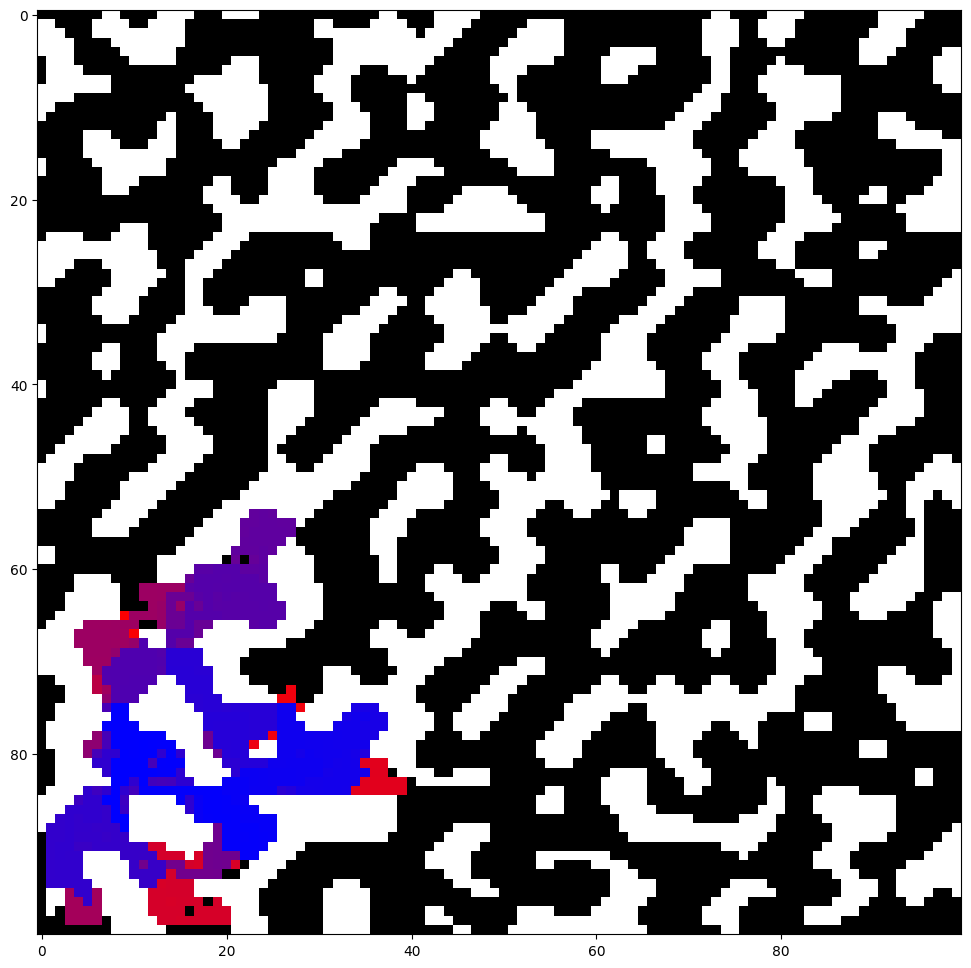

In [84]:
plot_trajectory(grid, trajectory)

In [8]:
# WHEN AT POSITION X,Y
def get_visible(grid, x,y):
    """
    Get the slice of array which is visible to the agent from position x,y
    """
    padding = ((1, 1), (1, 1))
    padded_grid = np.pad(grid, padding, mode='constant', constant_values=-1)
    visible_space = padded_grid[x:x+3, y:y+3]

    return visible_space

## Converting to RL environment
- State = visible patch, current position
- Action = move
- reward = -1
- terminal condition = Whole grid is explored 

In [45]:
class GridEnv():
    def __init__(self, size=100):
        self.height, self.width = size, size
        
        perlin_noise_grid = perlin_noise(width, height, scale=6)
        grid = (perlin_noise_grid > 0.1) * 1
        grid = np.float32(grid)
        
        grid_copy = grid.copy()
        flood_fill(grid_copy, start_point=(0,0), new_value=0.5)
        mask = (grid_copy == 0)
        self.grid = grid + mask\
        
        self.actions = {
            "UP" : (0, 1), 
            "DOWN" : (0, -1), 
            "LEFT" : (-1, 0), 
            "RIGHT" : (1, 0),
        }
        self.agent_start_position = np.array((0,0))
        self.agent_position = self.agent_start_position

    def reset():
        self.agent_position = self.agent_start_position
        done = False
        return state, done
    
    def step(self, action):
        movement = self.actions[action]
        new_position = self.agent_position + movement
        done = False

        if 0 < new_pos[0] < self.height-1 and 0 < new_pos[1] < self.width-1 and self.grid[tuple(new_pos)] != 1:
            current_pos = new_pos
            trajectory.append(tuple(current_pos))
            done = True
            reward = -100

            return new_pos, reward, done

    def sample_action(self):
        return random.choice(list(self.actions.keys()))


In [52]:
env = GridEnv(size=100)
env.sample_action()

'LEFT'

## Agent
- Take random action
- Note trajectory, current position, and visible patch at all times
- Agent can take random action
- Agent needs to add current poision to trajectory
- Agent 

In [ ]:
class Agent():
    def __init__(self):
        self.trajectory = []
        self.position = np.array((0,0))
        self.visible_patch = np.zeros((3,3))

    def 